## Loading and Prepping the Data

In [63]:
import pandas as pd
import numpy as np

In [64]:
data=pd.read_csv('../data/phonemeData.txt', sep='\t', header=None)

In [65]:
data.head()

0        1    2        3        4      5       6         7         8    \
0    1    Hadza  hts  hts-TZA  Khoisan    800  Africa  -3.47684  34.79905   
1    2  Sandawe  sad  sad-TZA  Khoisan  40000  Africa  -5.28543  35.46569   
2    3     Qxu^  knw  knw-NAM  Khoisan   1760  Africa -19.47014  18.35209   
3    4     Qxu^  ktz  ktz-NAM  Khoisan  28600  Africa -19.76648  20.09317   
4    5     Qxu^  ktz  ktz-NAM  Khoisan  28600  Africa -19.76648  20.09317   

   9    ...  727  728  729  730  731  732  733  734  735  736  
0    0  ...    0    0    0    0    0    0    0    0    0    0  
1    0  ...    0    0    0    0    0    0    0    0    0    0  
2    0  ...    0    0    0    0    0    0    0    0    0    0  
3    0  ...    0    0    0    0    0    0    0    0    0    0  
4    0  ...    0    0    0    0    0    0    0    0    0    0  

[5 rows x 737 columns]

In [66]:
#Rename the columns
newColumns = data.columns.tolist()

newColumns[0] = "Language Number"
newColumns[1] = "Name"
newColumns[2] = "ISO Code"
newColumns[3] = "ISO A3 Code"
newColumns[4] = "Language Classification"
newColumns[5] = "Speaking Pop Size"
newColumns[6] = "Geographic Region"
newColumns[7] = "Latitude"
newColumns[8] = "Longitude"
for i in range(728):
    startPhonemeIndex = 9
    newColumns[startPhonemeIndex + i] = "Phoneme " + str(i)

#newColumns

In [67]:
data.columns = newColumns
data.head()

Language Number     Name ISO Code ISO A3 Code Language Classification  \
0                1    Hadza      hts     hts-TZA                 Khoisan   
1                2  Sandawe      sad     sad-TZA                 Khoisan   
2                3     Qxu^      knw     knw-NAM                 Khoisan   
3                4     Qxu^      ktz     ktz-NAM                 Khoisan   
4                5     Qxu^      ktz     ktz-NAM                 Khoisan   

   Speaking Pop Size Geographic Region  Latitude  Longitude  Phoneme 0  ...  \
0                800            Africa  -3.47684   34.79905          0  ...   
1              40000            Africa  -5.28543   35.46569          0  ...   
2               1760            Africa -19.47014   18.35209          0  ...   
3              28600            Africa -19.76648   20.09317          0  ...   
4              28600            Africa -19.76648   20.09317          0  ...   

   Phoneme 718  Phoneme 719  Phoneme 720  Phoneme 721  Phoneme 722  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Phoneme 723  Phoneme 724  Phoneme 725  Phoneme 726  Phoneme 727  
0            0            0            0            0            0  
1            0            0            0            0            0  
2            0            0            0            0            0  
3            0            0            0            0            0  
4            0            0            0            0            0  

[5 rows x 737 columns]

In [68]:
#Remove duplicates
data = data.drop_duplicates(keep = False, subset=data.columns.difference(['Language Number']))

In [69]:
#About 10 rows were duplicates
data.shape

(2072, 737)

Notes: https://www.ethnologue.com
is where you can paste in the ISO code to see that it's a real language, the "Name" column that is provided might not be super accurate

## Similarity Metrics

### Hamming Distance

In [70]:
### Hamming distance
def hamming_distance(bin_list1, bin_list2):
    if len(bin_list1) != len(bin_list2):
        raise ValueError("Binary lists must have the same length")

    distance = 0
    for i in range(len(bin_list1)):
        if bin_list1[i] != bin_list2[i]:
            distance += 1

    return distance

In [71]:
bukaRow = data.loc[data['Name'] == "N/amani"]
bukaRow = bukaRow.iloc[:, 9:]
# #A list of the phoneme values
bukaRowList = list(bukaRow.values)

hammingDistanceMapToBukaRoot = {}


In [72]:
### Calculate Hamming distance for all
#Map the distances to language
for index, row in data.iterrows():
    #We actually want to include the base root in this map because it'll have 
    #perfect score and be our first value (root)

    languageName = row['Name']
    languagePhonemes = row.iloc[9:]
    # print(list(languagePhonemes.values))
    languagePhonemesList = list(languagePhonemes.values)
    hammingDistance = hamming_distance(bukaRowList[0], languagePhonemesList)
    #print(f"Hamming Distance between lists: {hammingDistance}")

    hammingDistanceMapToBukaRoot[languageName] = hammingDistance


In [73]:
treeData = data

# Now let's find the majority value for each Language Classification
def majority_value(group):
    phoneme_cols = [col for col in group.columns if col.startswith('Phoneme')]
    majority_row = {}
    for col in phoneme_cols:
        value_counts = group[col].value_counts()
        #print(value_counts)
        # Get the value with the highest count
        majority_value = value_counts.idxmax()
        #print(majority_value)
        # Store the majority value for the column
        majority_row[col] = majority_value
    return pd.Series(majority_row)

# Group by Language Classification and apply the majority_value function
groupedTreeData = treeData.groupby('Language Classification').apply(majority_value).reset_index()

#print(groupedTreeData)

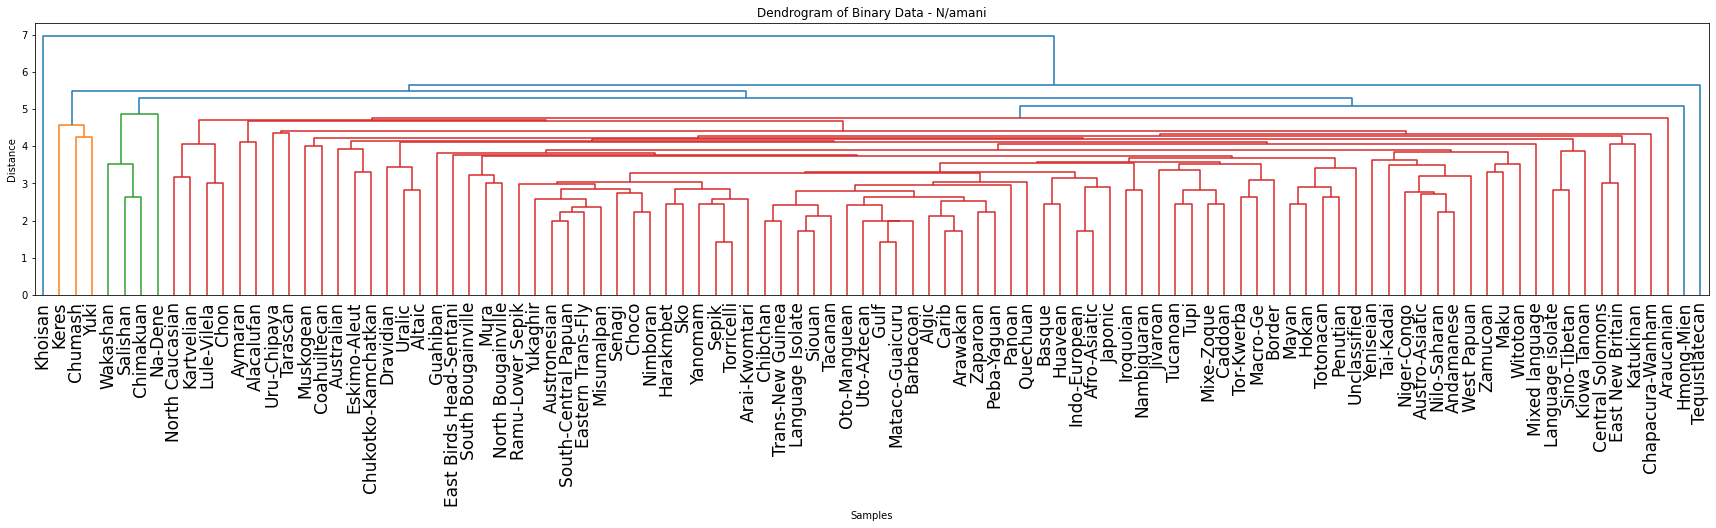

In [74]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

binary_data = groupedTreeData.iloc[:, 1:].values  # Assuming binary data starts from column 1

distance_matrix = hierarchy.distance.pdist(binary_data, metric='euclidean')

Z = hierarchy.linkage(distance_matrix, method='average', optimal_ordering=True)

# Plot dendrogram
plt.figure(figsize=(30, 5))
dn = hierarchy.dendrogram(Z, labels=groupedTreeData.iloc[:, 0].values, leaf_rotation=90)
plt.title('Dendrogram of Binary Data - N/amani')
plt.xlabel('Samples')
plt.xticks(fontsize=17, rotation=90)
plt.ylabel('Distance')
plt.show()


In [75]:
names = list(hammingDistanceMapToBukaRoot.keys())
clustering = data[data['Name'].isin(names)]
clustering['Distances'] = data['Name'].map(hammingDistanceMapToBukaRoot)

In [76]:
import plotly.express as px
import pandas as pd


# Create scatter map
fig = px.scatter_geo(clustering, lat='Latitude', lon='Longitude', color='Distances',
                     hover_name='Name', #size='mag',
                     title='Clustering by Phoneme Hamming Distance - N/amani')
fig.show()

In [77]:
lat_lon_distance = {}
for _, row in clustering.iterrows():
    d = row['Distances']
    if d not in lat_lon_distance:
        lat_lon_distance[d] = []
    lat_lon_distance[d].append((row['Latitude'], row['Longitude']))

In [78]:
def ConvertIntToColor(x):
    scaled = int((x / 94)*255)
    head = "#ff"
    tail = str(hex(scaled))[2:]
    if len(tail) == 1:
        tail = "0" + tail
    return head + tail + tail

In [79]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add scattergeo plot for the initial locations
scatter = fig.add_trace(
    go.Scattergeo(
        mode='markers+text',
        textposition='top center',
        marker=dict(
           size=10,
           color='red',
           opacity=0.7,
        ),
        name='Cities'
    )
)

# Set initial layout properties
fig.update_layout(
    title='Spread of Languages by Phoneme Hamming Distance - N/amani',
    geo=dict(
        scope='world',
        showland=True,
    )
)


# Add frames for animation
frames = []
locations_list = lat_lon_distance.values()
max_dist = max(lat_lon_distance.keys())

all_locations = []
# distances = []
for i, locations in dict(sorted(lat_lon_distance.items())).items():
    c = ConvertIntToColor(i)
    all_locations.extend(locations)
    # distances.append(i)
    frame_data = go.Frame(
        data=[
            go.Scattergeo(
                lon=[loc[1] for loc in all_locations],
                lat=[loc[0] for loc in all_locations],
                mode='markers+text',
                textposition='top center',
                marker=dict(
                    size=5,
                    # color = ConvertIntToColor(i),  # Assign color based on distances
                    # colorscale='thermal', 
                    color= "Red",
                    opacity=0.3
                )
            )
        ],
    )
    frames.append(frame_data)

# Add frames to the figure
fig.frames = frames

# Update animation settings
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 300, "redraw": True}, "fromcurrent": True, "mode": "immediate"}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
)

# Show the plot
fig.show()

### Hashing Distance

In [80]:
import hashlib

def hashBinaryList(binaryList):
    # Convert the binary list to bytes
    binaryBytes = bytes(binaryList)
    # Hash the bytes using SHA-256
    hashObject = hashlib.sha256(binaryBytes)
    # Get the hexadecimal representation of the hash
    hashHex = hashObject.hexdigest()
    
    return hashHex


In [81]:
def hashDistance(hash1, hash2):
    distance = 0
    for char1, char2 in zip(hash1, hash2):
        # Convert hexadecimal characters to integers and calculate the absolute difference
        distance += abs(int(char1, 16) - int(char2, 16))
    
    return distance

In [82]:
bukaRow = data.loc[data['Name'] == "N/amani"]
bukaRow = bukaRow.iloc[:, 9:]
#A list of the phoneme values
bukaRowList = list(bukaRow.values[0])
bukaHash = hashBinaryList(bukaRowList)

hashingDistanceMapToBukaRoot = {}


In [83]:
#Map the distances to language
for index, row in data.iterrows():
    #We actually want to include the base root in this map because it'll have 
    #perfect score and be our first value (root)

    languageName = row['Name']
    languagePhonemes = row.iloc[9:]
    languagePhonemesList = list(languagePhonemes.values)
    languageHash = hashBinaryList(languagePhonemesList)
    hashingDistance = hashDistance(bukaHash, languageHash)
    #print(f"Hashing Distance between lists: {hashingDistance}")

    hashingDistanceMapToBukaRoot[languageName] = hashingDistance


In [84]:
print(hashingDistanceMapToBukaRoot)

{'Hadza': 329, 'Sandawe': 300, 'Qxu^': 366, 'Nama': 320, '!Ora': 353, 'G//abake': 372, 'Shua': 302, 'Danisin': 339, 'Deti': 360, 'Kxoe': 353, 'Buka': 282, 'Handa': 282, 'Xu^': 314, 'G//ana': 328, 'G/wi': 338, 'Naron': 343, '\\u450?Hu^': 328, 'N/amani': 0, 'N/huki': 363, 'Katcha': 313, 'Katla': 387, 'Ko': 318, 'Warnang': 340, 'Rere': 364, 'Utoro': 353, 'Logol': 340, 'Ebang': 325, 'Laru': 303, 'Shirumba': 319, 'Tiro': 423, 'Moro': 372, 'Tegem': 305, 'Nding': 335, 'Jomang': 357, 'Tocho': 343, 'Ngile': 395, 'Dengebu': 297, 'Tegali': 325, 'Soninke': 296, 'Susu': 317, 'Vai': 352, 'Mandinka': 324, 'Maninka': 318, 'Bambara': 380, 'Dyula': 403, 'Loko\\sub 1\\nosupersub': 325, 'Loma': 341, 'Kpelle': 335, 'Mende': 268, 'Dan': 315, 'Kweni': 321, 'Tura': 379, 'Bisa': 357, 'Sane': 348, 'San': 330, 'Fula': 342, 'Wolof': 376, 'Balant': 316, 'Ganja': 359, 'Mankan': 313, 'Manjaku': 315, 'Diola': 350, 'Badyara': 330, 'Banyun': 332, 'Basari': 357, 'Bedik': 289, 'Temne': 288, 'Southern Bullom': 349, 'Seme'

In [85]:
#Store the languages and locations
languageLocations = {}
for index, row in data.iterrows():
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    languageName = row["Name"]
    languageLocations[languageName] = (latitude, longitude)
    #print(index)

# Sort the hashingDistanceMapToBukaRoot dictionary by values (scores)
sortedLanguages = sorted(hashingDistanceMapToBukaRoot, key=lambda x: hashingDistanceMapToBukaRoot[x])

In [86]:
#print(sortedLanguages)

In [87]:
# Group languages by their scores
groupedLanguages = {}
for lang in sortedLanguages:
    score = hashingDistanceMapToBukaRoot[lang]
    if score in groupedLanguages:
        groupedLanguages[score].append(lang)
    else:
        groupedLanguages[score] = [lang]

# Create a 2D list where each sublist contains languages with the same score
orderedLanguageLocations = []
for score in sorted(groupedLanguages.keys()):
    orderedLanguageLocations.append([(lang, languageLocations[lang]) for lang in groupedLanguages[score]])



In [88]:
treeData = data

# Now let's find the majority value for each Language Classification
def majority_value(group):
    phoneme_cols = [col for col in group.columns if col.startswith('Phoneme')]
    majority_row = {}
    for col in phoneme_cols:
        value_counts = group[col].value_counts()
        #print(value_counts)
        # Get the value with the highest count
        majority_value = value_counts.idxmax()
        #print(majority_value)
        # Store the majority value for the column
        majority_row[col] = majority_value
    return pd.Series(majority_row)

# Group by Language Classification and apply the majority_value function
groupedTreeData = treeData.groupby('Language Classification').apply(majority_value).reset_index()

print(groupedTreeData)

    Language Classification  Phoneme 0  Phoneme 1  Phoneme 2  Phoneme 3  \
0              Afro-Asiatic          0          0          0          0   
1                Alacalufan          0          0          0          0   
2                     Algic          0          0          0          0   
3                    Altaic          0          0          0          0   
4                Andamanese          0          0          0          0   
..                      ...        ...        ...        ...        ...   
97                Yeniseian          0          0          0          0   
98                 Yukaghir          0          0          0          0   
99                     Yuki          0          0          0          0   
100                Zamucoan          0          0          0          0   
101                Zaparoan          0          0          0          0   

     Phoneme 4  Phoneme 5  Phoneme 6  Phoneme 7  Phoneme 8  ...  Phoneme 718  \
0            0     

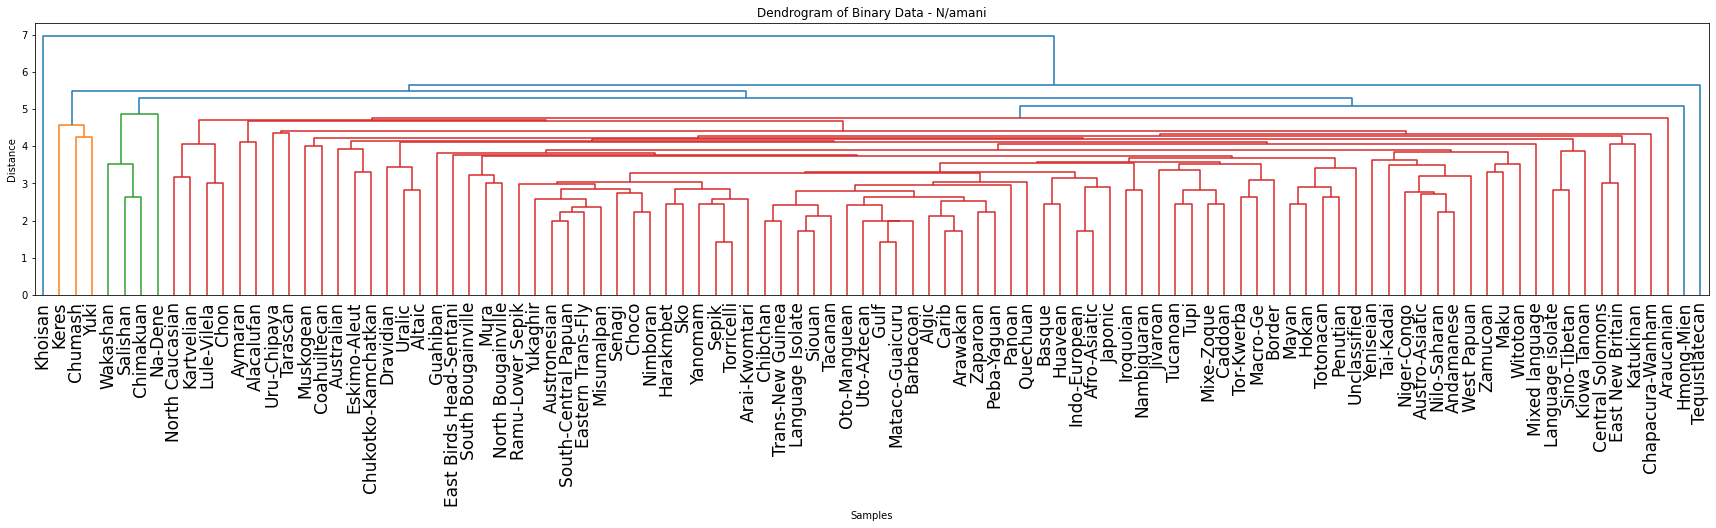

In [89]:
binary_data = groupedTreeData.iloc[:, 1:].values  # Assuming binary data starts from column 1

distance_matrix = hierarchy.distance.pdist(binary_data, metric='euclidean')

Z = hierarchy.linkage(distance_matrix, method='average', optimal_ordering=True)

# Plot dendrogram
plt.figure(figsize=(30, 5))
dn = hierarchy.dendrogram(Z, labels=groupedTreeData.iloc[:, 0].values, leaf_rotation=90)
plt.title('Dendrogram of Binary Data - N/amani')
plt.xlabel('Samples')
plt.xticks(fontsize=17, rotation=90)
plt.ylabel('Distance')
plt.show()


In [90]:
names = list(hashingDistanceMapToBukaRoot.keys())
clustering = data[data['Name'].isin(names)]
clustering['Distances'] = data['Name'].map(hashingDistanceMapToBukaRoot)

In [91]:
# Create scatter map
fig = px.scatter_geo(clustering, lat='Latitude', lon='Longitude', color='Distances',
                     hover_name='Name', #size='mag',
                     title='Clustering by Phoneme Hashing Distance - N/amani')
fig.show()

In [92]:
lat_lon_distance = {}
for _, row in clustering.iterrows():
    d = row['Distances']
    if d not in lat_lon_distance:
        lat_lon_distance[d] = []
    lat_lon_distance[d].append((row['Latitude'], row['Longitude']))

In [93]:
fig = go.Figure()

# Add scattergeo plot for the initial locations
scatter = fig.add_trace(
    go.Scattergeo(
        mode='markers+text',
        textposition='top center',
        marker=dict(
           size=10,
           color='red',
           opacity=0.7,
        ),
        name='Cities'
    )
)

# Set initial layout properties
fig.update_layout(
    title='Spread of Languages by Phoneme Hashing Distance - N/amani',
    geo=dict(
        scope='world',
        showland=True,
    )
)


# Add frames for animation
frames = []
locations_list = lat_lon_distance.values()
max_dist = max(lat_lon_distance.keys())

all_locations = []
# distances = []
for i, locations in dict(sorted(lat_lon_distance.items())).items():
    c = ConvertIntToColor(i)
    all_locations.extend(locations)
    # distances.append(i)
    frame_data = go.Frame(
        data=[
            go.Scattergeo(
                lon=[loc[1] for loc in all_locations],
                lat=[loc[0] for loc in all_locations],
                mode='markers+text',
                textposition='top center',
                marker=dict(
                    size=5,
                    # color = ConvertIntToColor(i),  # Assign color based on distances
                    # colorscale='thermal', 
                    color= "Red",
                    opacity=0.3
                )
            )
        ],
    )
    frames.append(frame_data)

# Add frames to the figure
fig.frames = frames

# Update animation settings
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 300, "redraw": True}, "fromcurrent": True, "mode": "immediate"}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
)

# Show the plot
fig.show()